<a href="https://colab.research.google.com/github/MICR-21/100-Days-of-python-code-vs/blob/main/Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up the Kaggle Dataset

In [2]:
!pip install kaggle


In [3]:
from google.colab import files
files.upload()  # This will let you upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"charlesgacari","key":"7bd03565f0d72e4d0dc014f22bbfa22f"}'}

# Set Up Kaggle API Credentials

In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"  # Set the directory path for kaggle.json


# Download the Dataset from Kaggle

In [5]:
!kaggle datasets download -d uciml/breast-cancer-wisconsin-data


Dataset URL: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data
License(s): CC-BY-NC-SA-4.0


# Extract the Dataset

In [6]:
!unzip breast-cancer-wisconsin-data.zip


Archive:  breast-cancer-wisconsin-data.zip
  inflating: data.csv                


# Import the dataset

- pands and numpy help handle and process data easily.
- matplotlib.pyplot and seaborn are used for creating visualizations e.g. confusion matrix and ROC curves.
- sklearn.model_selection.train_test_split helps split the dataset into training and testing sets.
- sklearn.metrics provides the tools needed to evaluate the performance of the model like ROC curve metrics.

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, RocCurveDisplay
)

# Load and Exploring the dataset

The dataset was first loaded and cleaned by removing the 'id' column, which had no predictive value. The diagnosis labels ('M' for malignant and 'B' for benign) were converted into binary values (1 and 0, respectively) to make them compatible with numerical computation. e.g **data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})**

Feature values were normalized using MinMaxScaler to ensure all features were on the same scale, which is important for maintaining the balance of influence across features, especially when calculating probabilities in the Naive Bayes model.

After preprocessing, the dataset was split into training and test sets using an 80/20 ratio. **Setting random_state = 42 ensures the split is the same each time the code is run.** This ensures that the model is trained on a majority of the data but evaluated on a separate, unseen portion. Such a split is crucial to prevent overfitting and to test the model's generalization ability on new, real-world data.

In [8]:
# Load the dataset (the csv file after unzipping)
data = pd.read_csv('data.csv')

# Display the first few rows
data.head()

# Drop the 'id' and 'Unnamed: 32' columns
data.drop(['id', 'Unnamed: 32'], axis=1, inplace=True)

# Encode 'diagnosis': M -> 1, B -> 0
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

# Split features and target
X = data.drop('diagnosis', axis=1).values
y = data['diagnosis'].values

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Implementing the Naive Bayes Classifier

A Gaussian Naive Bayes classifier was implemented manually using NumPy. The algorithm calculates the prior probabilities for each class and assumes each feature follows a Gaussian distribution.

For each class, the mean and variance of each feature were computed. The fit method calculates the mean and variance of each feature for each class (0 or 1) and the prior probability of each class.

The predict method uses Bayes' theorem to predict the class for new data points based on the statistics calculated.

These steps were essential to understand the inner workings of Naive Bayes and how it applies Bayes' Theorem with the naive assumption of feature independence.


Key Formula Recap:
𝑃
(
𝑐
𝑙
𝑎
𝑠
𝑠
∣
𝑓
𝑒
𝑎
𝑡
𝑢
𝑟
𝑒
𝑠
)
∝
𝑃
(
𝑐
𝑙
𝑎
𝑠
𝑠
)
×
∏
𝑃
(
𝑓
𝑒
𝑎
𝑡
𝑢
𝑟
𝑒
𝑖
∣
𝑐
𝑙
𝑎
𝑠
𝑠
)
P(class∣features)∝P(class)×∏P(feature
i
​
 ∣class)

In [9]:
class NaiveBayesClassifier:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = np.mean(X_c, axis=0)
            self.var[c] = np.var(X_c, axis=0) + 1e-9  # Prevent division by zero
            self.priors[c] = X_c.shape[0] / X.shape[0]

    def _pdf(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(- (x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def _predict_single(self, x):
        posteriors = []

        for c in self.classes:
            prior = np.log(self.priors[c])
            class_conditional = np.sum(np.log(self._pdf(c, x)))
            posterior = prior + class_conditional
            posteriors.append(posterior)

        return self.classes[np.argmax(posteriors)]

    def predict(self, X):
        return np.array([self._predict_single(x) for x in X])

    def predict_proba(self, X):
        proba = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.priors[c])
                class_conditional = np.sum(np.log(self._pdf(c, x)))
                posterior = prior + class_conditional
                posteriors.append(posterior)
            # Convert log probabilities back to normal scale
            posteriors = np.exp(posteriors - np.max(posteriors))  # For numerical stability
            proba.append(posteriors / np.sum(posteriors))
        return np.array(proba)


#Train the Model

The training phase involved computing and storing the statistical parameters (mean, variance, and prior) for each class from the training data. These parameters summarize the data distribution and are used to estimate the likelihood of a test sample belonging to each class during prediction. This step builds the foundational knowledge the model uses for inference.

An instance of the NaiveBayes class and call **fit** to train the model on the training data. During this step, the model learns the mean, variance, prior probabilities of the data for each class.

In [10]:
# Initialize and train the classifier
nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)


# Make Predictions

Once trained, the model was used to predict labels on the test set. For each test instance, it computed the posterior probability of it being in each class and assigned the class with the highest probability. This step showcases the actual application of Bayes’ Theorem in classifying unknown instances using the learned distributions.

In [11]:
# Make predictions on the test set
y_pred = nb.predict(X_test)


# Evaluate the Model

The model's predictions were evaluated using accuracy, precision, recall, and F1-score. Each metric provides a different perspective: accuracy shows overall correctness, precision tells how many predicted positives were correct, recall shows how many actual positives were detected, and F1-score balances precision and recall. This comprehensive evaluation helps in understanding both the strengths and weaknesses of the model.

In [12]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9649
Precision: 0.9756
Recall: 0.9302
F1 Score: 0.9524


# Visualizing Evaluation Metrics in a Bar Chart

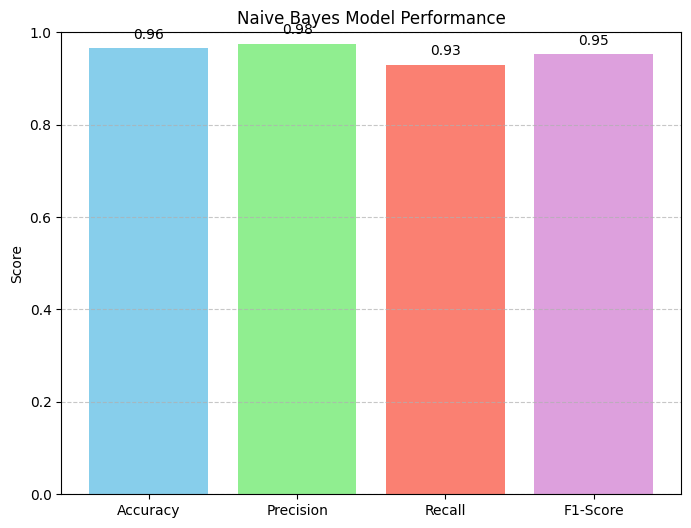

In [16]:
# Labels and values
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [accuracy, precision, recall, f1]

# Plotting
plt.figure(figsize=(8, 6))
bars = plt.bar(metrics, scores, color=['skyblue', 'lightgreen', 'salmon', 'plum'])
plt.ylim(0, 1)
plt.title('Naive Bayes Model Performance')
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.02, f'{yval:.2f}', ha='center', fontsize=10)

plt.show()


# Visualize the Confusion Matrix

The confusion matrix is generated to visualize how many predictions were correct and where the model may have made mistakes e.g false positives and negatives. We plot it using seabord to make it easier to intercept.

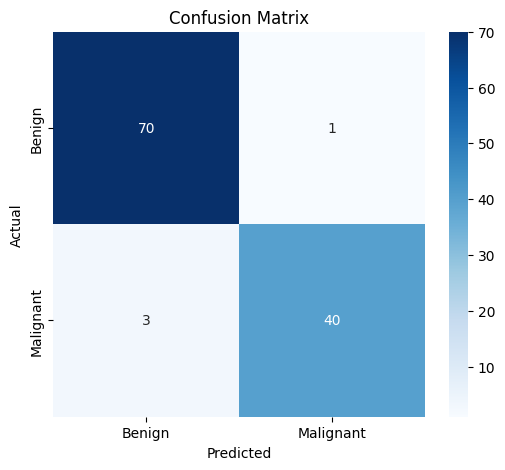

In [18]:
import seaborn as sns
plt.figure(figsize=(6, 5))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Plot the ROC Curve

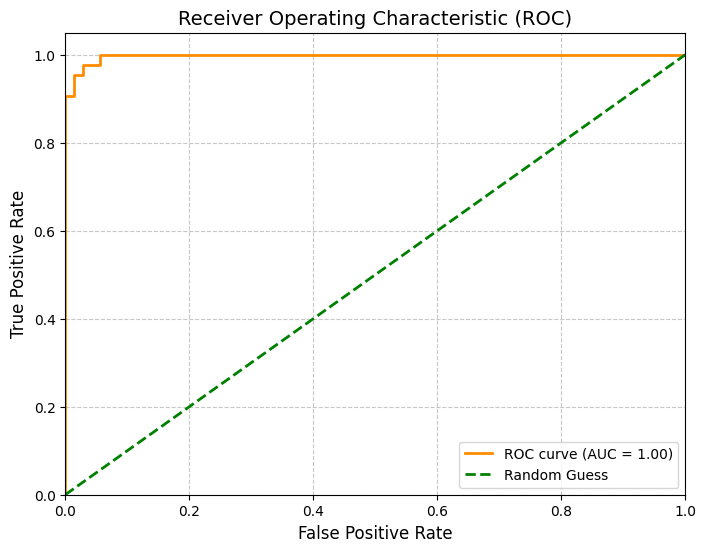

In [20]:
# Get scores and calculate ROC metrics
y_scores = nb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot with labels and styling
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='green', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# Step 9: Bayes’ Theorem Explained in My Own Words
Bayes’ Theorem helps us update our beliefs about something based on new evidence. In classification, we want to know the probability of a class (e.g., species of a flower) given the observed features (like petal length).

Instead of guessing blindly, we use the formula:

𝑃(𝐶𝑙𝑎𝑠𝑠∣𝐹𝑒𝑎𝑡𝑢𝑟𝑒𝑠)=𝑃(𝐹𝑒𝑎𝑡𝑢𝑟𝑒𝑠∣𝐶𝑙𝑎𝑠𝑠) * P
(𝐶𝑙𝑎𝑠𝑠) / 𝑃(𝐹𝑒𝑎𝑡𝑢𝑟𝑒𝑠)


In Naive Bayes, we assume the features are independent (which is rarely true, but works surprisingly well). This lets us calculate:

Prior (P(Class)): How common the class is

Likelihood (P(Features|Class)): How likely these features appear in that class

Posterior (P(Class|Features)): The final score for that class, given the data